*1. EDA*

In [1]:
import os

IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except Exception:
    pass

meta_path = os.path.join("/content/drive/MyDrive/rag/nlp/arxiv-metadata-s.json")
test_path = os.path.join("/content/drive/MyDrive/rag/nlp/test_sample.csv")

print("meta_path:", meta_path, "exists:", os.path.exists(meta_path))
print("test_path:", test_path, "exists:", os.path.exists(test_path))
assert os.path.exists(meta_path), "arxiv-metadata-s.json not found."
assert os.path.exists(test_path), "test_sample.csv not found."


Mounted at /content/drive
meta_path: /content/drive/MyDrive/rag/nlp/arxiv-metadata-s.json exists: True
test_path: /content/drive/MyDrive/rag/nlp/test_sample.csv exists: True


In [2]:
import json
import pandas as pd
import numpy as np

def load_arxiv_metadata(path: str, max_rows: int | None = 50000) -> pd.DataFrame:
    try:
        df = pd.read_json(path, lines=True)
        if max_rows is not None and len(df) > max_rows:
            df = df.iloc[:max_rows].copy()
        return df
    except ValueError:
        pass

    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if isinstance(data, list):
        if max_rows is not None and len(data) > max_rows:
            data = data[:max_rows]
        return pd.json_normalize(data)

    if isinstance(data, dict):
        for k, v in data.items():
            if isinstance(v, list) and v and isinstance(v[0], dict):
                if max_rows is not None and len(v) > max_rows:
                    v = v[:max_rows]
                return pd.json_normalize(v)

    raise ValueError("Неизвестная структура arxiv-metadata-s.json")

meta_df = load_arxiv_metadata(meta_path, max_rows=50000)
test_df = pd.read_csv(test_path)

keep_cols = [c for c in ["id", "title", "abstract"] if c in meta_df.columns]
meta_df = meta_df[keep_cols].copy()

print("meta_df.shape:", meta_df.shape)
print("test_df.shape:", test_df.shape)
meta_df.head(2), test_df.head(2)


meta_df.shape: (50000, 3)
test_df.shape: (1000, 3)


(          id                                              title  \
 0  0704.0038  The discrete dipole approximation: an overview...   
 1  0704.0057  High-spin to low-spin and orbital polarization...   
 
                                             abstract  
 0    We present a review of the discrete dipole a...  
 1    We study the interplay of crystal field spli...  ,
                 id                                           abstract  \
 0       2412.16732    A new platinate was recently discovered when...   
 1  nucl-th/9602019    The production cross sections of various fra...   
 
                                                query  
 0  What unique composition and decomposition beha...  
 1  How does the inclusion of statistical decay af...  )

In [3]:
def str_len(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.len()

def word_count(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.split().map(len)

summary = {
    "rows_meta": len(meta_df),
    "rows_test": len(test_df),
    "nulls_meta": meta_df.isna().sum().to_dict(),
    "nulls_test": test_df.isna().sum().to_dict(),
}

dups = int(meta_df["id"].duplicated().sum()) if "id" in meta_df.columns else None
summary["duplicate_ids_meta"] = dups

print(summary)

length_stats = []
if "title" in meta_df.columns:
    s = str_len(meta_df["title"])
    w = word_count(meta_df["title"])
    length_stats += [("title_chars", s), ("title_words", w)]
if "abstract" in meta_df.columns:
    s = str_len(meta_df["abstract"])
    w = word_count(meta_df["abstract"])
    length_stats += [("abstract_chars", s), ("abstract_words", w)]

rows = []
for name, ser in length_stats:
    rows.append({
        "field": name,
        "count": int(ser.count()),
        "mean": float(ser.mean()),
        "std": float(ser.std()),
        "min": int(ser.min()) if len(ser) else None,
        "p50": float(ser.quantile(0.50)),
        "p90": float(ser.quantile(0.90)),
        "p99": float(ser.quantile(0.99)),
        "max": int(ser.max()) if len(ser) else None,
    })
pd.DataFrame(rows)

{'rows_meta': 50000, 'rows_test': 1000, 'nulls_meta': {'id': 0, 'title': 0, 'abstract': 0}, 'nulls_test': {'id': 0, 'abstract': 0, 'query': 0}, 'duplicate_ids_meta': 0}


,field,count,mean,std,min,p50,p90,p99,max
0,title_chars,50000,74.30244,27.616602,7,71.0,111.0,153.0,246
1,title_words,50000,9.78678,3.739903,1,9.0,15.0,21.0,37
2,abstract_chars,50000,947.84658,427.020475,32,909.0,1568.0,1906.0,3874
3,abstract_words,50000,140.70342,64.149221,5,134.0,235.0,293.0,584


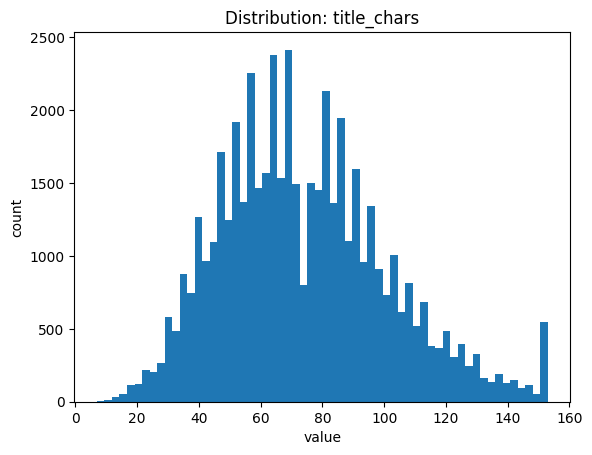

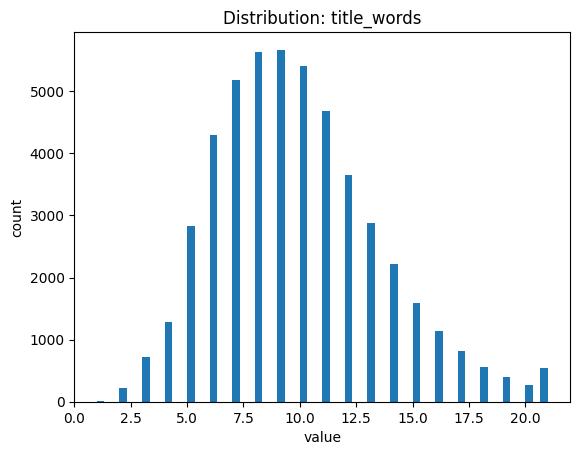

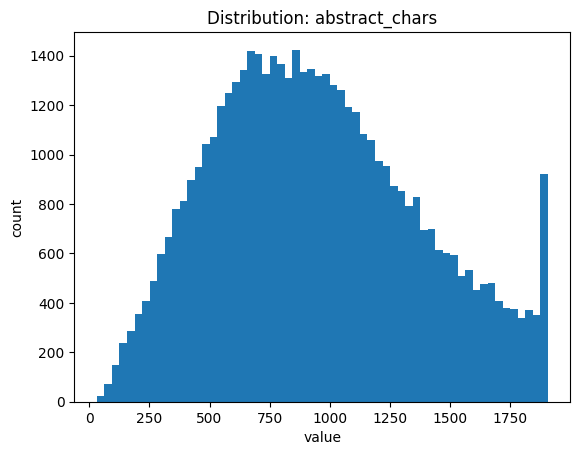

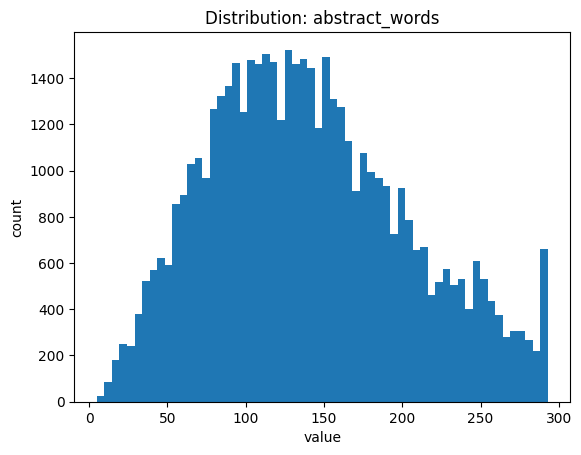

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(series: pd.Series, title: str, bins: int = 60):
    plt.figure()
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean) == 0:
        print(f"Skip {title}: empty.")
        return
    q99 = clean.quantile(0.99)
    clipped = clean.clip(upper=q99)
    plt.hist(clipped, bins=bins)
    plt.title(title)
    plt.xlabel("value")
    plt.ylabel("count")
    plt.show()

for name, ser in length_stats:
    plot_hist(ser, f"Distribution: {name}")


In [5]:
coverage = None
if "id" in meta_df.columns and "id" in test_df.columns:
    meta_ids = set(meta_df["id"].astype(str))
    test_ids = set(test_df["id"].astype(str))
    covered = sum(1 for i in test_ids if i in meta_ids)
    coverage = {
        "unique_test_ids": len(test_ids),
        "covered_in_meta_subset": covered,
        "coverage_ratio": covered / max(1, len(test_ids))
    }
coverage

{'unique_test_ids': 1000,
 'covered_in_meta_subset': 516,
 'coverage_ratio': 0.516}

Выводы:
- Данные чистые, структурированные, без значимых пропусков и дубликатов.
- Заголовки короткие и однородные (≈ 10 слов).
- Аннотации длиннее, но укладываются в разумные пределы (≈ 140 слов).
- Распределения без выбросов, корпус сбалансирован.
- Можно использовать объединённый текст title + abstract для поиска, так как это одновременно дает ключевые слова и краткий контекст.
- При токенизации достаточно max_length ≈ 512–1024.

*2. Реализация retrieval-системы*

In [6]:

!pip install faiss-cpu
from typing import List, Optional, Dict, Tuple
import os, json, time, math
import numpy as np
import pandas as pd

import faiss
import torch
from torch import Tensor
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except Exception:
    pass

meta_path = os.path.join("/content/drive/MyDrive/rag/nlp/arxiv-metadata-s.json")
test_path = os.path.join("/content/drive/MyDrive/rag/nlp/test_sample.csv")

print("meta_path:", meta_path, "exists:", os.path.exists(meta_path))
print("test_path:", test_path, "exists:", os.path.exists(test_path))
assert os.path.exists(meta_path), "arxiv-metadata-s.json not found."
assert os.path.exists(test_path), "test_sample.csv not found."

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 77.1 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
meta_path: /content/drive/MyDrive/rag/nlp/arxiv-metadata-s.json exists: True
test_path: /content/drive/MyDrive/rag/nlp/test_sample.csv exists: True


In [7]:
def load_arxiv_metadata(path: str, max_rows: int | None = None) -> pd.DataFrame:

    try:
        df = pd.read_json(path, lines=True)
        if max_rows and len(df) > max_rows:
            df = df.iloc[:max_rows].copy()
        return df
    except ValueError:
        pass

    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, list):
        if max_rows and len(data) > max_rows:
            data = data[:max_rows]
        return pd.json_normalize(data)
    if isinstance(data, dict):
        for k, v in data.items():
            if isinstance(v, list) and v and isinstance(v[0], dict):
                if max_rows and len(v) > max_rows:
                    v = v[:max_rows]
                return pd.json_normalize(v)
    raise ValueError("Unknown JSON structure for arxiv-metadata-s.json")

meta_df = load_arxiv_metadata(meta_path, max_rows=None)
test_df = pd.read_csv(test_path)

keep = [c for c in ["id", "title", "abstract"] if c in meta_df.columns]
meta_df = meta_df[keep].copy()

def build_text(row) -> str:
    t = str(row.get("title", "") or "")
    a = str(row.get("abstract", "") or "")
    return (t + "\n\n" + a).strip()

meta_df["text"] = meta_df.apply(build_text, axis=1)
print("Corpus size:", len(meta_df))
meta_df.head(2), test_df.head(2)


Corpus size: 98213


(          id                                              title  \
 0  0704.0038  The discrete dipole approximation: an overview...   
 1  0704.0057  High-spin to low-spin and orbital polarization...   
 
                                             abstract  \
 0    We present a review of the discrete dipole a...   
 1    We study the interplay of crystal field spli...   
 
                                                 text  
 0  The discrete dipole approximation: an overview...  
 1  High-spin to low-spin and orbital polarization...  ,
                 id                                           abstract  \
 0       2412.16732    A new platinate was recently discovered when...   
 1  nucl-th/9602019    The production cross sections of various fra...   
 
                                                query  
 0  What unique composition and decomposition beha...  
 1  How does the inclusion of statistical decay af...  )

In [8]:
def truncate_words(text: str, max_words: int) -> str:
    ws = str(text or "").split()
    return " ".join(ws[:max_words]) if len(ws) > max_words else " ".join(ws)

class Profiler:
    def __init__(self): self.times = {}
    def measure(self, key: str, func, *args, **kwargs):
        t0 = time.perf_counter(); out = func(*args, **kwargs); dt = time.perf_counter() - t0
        self.times.setdefault(key, []).append(dt); return out
    def summary(self) -> pd.DataFrame:
        rows = []
        for k, vals in self.times.items():
            rows.append({"stage": k, "calls": len(vals),
                         "mean_s": float(np.mean(vals)),
                         "p90_s": float(np.percentile(vals, 90)),
                         "total_s": float(np.sum(vals))})
        return pd.DataFrame(rows).sort_values("total_s", ascending=False)

def mrr_at_k(ranked_ids: list[str], gold_id: str, k: int = 5) -> float:
    for idx, did in enumerate(ranked_ids[:k], start=1):
        if str(did) == str(gold_id):
            return 1.0 / idx
    return 0.0


In [9]:
import gc

class RAG:
    def __init__(
        self,
        embedder_name: str = "Qwen/Qwen3-Embedding-0.6B",
        reranker_name: str  = "Qwen/Qwen3-Reranker-0.6B",
        device: str | None = None,
        max_length_embed: int = 512,
        batch_size_embed: int = 8,
        dtype = torch.float16,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length_embed = max_length_embed
        self.batch_size_embed = batch_size_embed

        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(
            embedder_name,
            torch_dtype=dtype,
            low_cpu_mem_usage=True
        ).to(self.device)
        self.embedder.eval()

        self.rr_tokenizer = AutoTokenizer.from_pretrained(reranker_name, padding_side="left")
        self.reranker = AutoModelForCausalLM.from_pretrained(
            reranker_name,
            torch_dtype=dtype,
            low_cpu_mem_usage=True
        ).to(self.device)
        self.reranker.eval()

        self.token_false_id = self.rr_tokenizer.convert_tokens_to_ids("no")
        self.token_true_id  = self.rr_tokenizer.convert_tokens_to_ids("yes")

        prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".<|im_end|>\n<|im_start|>user\n"
        suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
        self.prefix_tokens = self.rr_tokenizer.encode(prefix, add_special_tokens=False)
        self.suffix_tokens = self.rr_tokenizer.encode(suffix, add_special_tokens=False)

        self.index: faiss.Index | None = None
        self.ids:   list[str] = []
        self.texts: list[str] = []

    def _generate_embeddings(self, texts: list[str]) -> np.ndarray:
        inputs = self.emb_tokenizer(
            texts, padding=True, truncation=True,
            return_tensors="pt", max_length=self.max_length_embed
        ).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):
            outputs = self.embedder(**inputs)
        reps = self.last_token_pool(outputs.last_hidden_state, inputs.attention_mask).detach().cpu()
        del outputs, inputs
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return F.normalize(reps, p=2, dim=1).numpy()

    @staticmethod
    def last_token_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding: return last_hidden_states[:, -1]
        seq_lens = attention_mask.sum(dim=1) - 1
        bsz = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(bsz, device=last_hidden_states.device), seq_lens]

    def build_index_from_df(
        self,
        df: pd.DataFrame,
        id_col: str = "id",
        text_col: str = "text",
        truncate_words_embed: int | None = 320,
    ) -> dict:
        t0 = time.perf_counter()

        self.ids = df[id_col].astype(str).tolist()
        self.texts = df[text_col].astype(str).tolist()
        if truncate_words_embed is not None:
            self.texts = [truncate_words(t, truncate_words_embed) for t in self.texts]

        self.index = None
        vector_dim = None
        bs_target = max(1, self.batch_size_embed)

        i, n = 0, len(self.texts)
        while i < n:
            cur_bs = min(bs_target, n - i)
            batch = self.texts[i:i+cur_bs]
            try:
                vecs = self._generate_embeddings(batch)
                if self.index is None:
                    vector_dim = vecs.shape[1]
                    self.index = faiss.IndexFlatL2(vector_dim)
                self.index.add(vecs)

                del vecs, batch
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

                i += cur_bs
                if bs_target < self.batch_size_embed:
                    bs_target = min(self.batch_size_embed, bs_target * 2)
            except RuntimeError as e:
                msg = str(e).lower()
                if ("out of memory" in msg) or ("cuda" in msg and "memory" in msg):
                    if torch.cuda.is_available(): torch.cuda.empty_cache()
                    new_bs = max(1, cur_bs // 2)
                    if new_bs == cur_bs: raise
                    bs_target = new_bs
                    print(f"[build_index_from_df] OOM -> reduce batch to {bs_target}")
                else:
                    raise

        return {"num_docs": len(self.ids),
                "build_seconds": time.perf_counter() - t0,
                "dim": int(vector_dim or 0)}

    def search(self, query: str, k: int = 10):
        if self.index is None: raise ValueError("Index not initialized")
        q_emb = self._generate_embeddings([query])
        return self.index.search(q_emb, k)

    def _format_pair(self, query: str, doc: str, instruction: str | None = None) -> str:
        if instruction is None:
            instruction = 'Given a web search query, retrieve relevant passages that answer the query'
        return "<Instruct>: {instruction}\n<Query>: {query}\n<Document>: {doc}".format(
            instruction=instruction, query=query, doc=doc
        )

    def _process_inputs(self, pairs: list[str], max_length_rerank: int = 1024):
        inputs = self.rr_tokenizer(
            pairs, padding=False, truncation='longest_first',
            return_attention_mask=False,
            max_length=max_length_rerank - len(self.prefix_tokens) - len(self.suffix_tokens)
        )
        for i, ids in enumerate(inputs['input_ids']):
            inputs['input_ids'][i] = self.prefix_tokens + ids + self.suffix_tokens
        inputs = self.rr_tokenizer.pad(inputs, padding=True, return_tensors="pt", max_length=max_length_rerank)
        for k in inputs: inputs[k] = inputs[k].to(self.device)
        return inputs

    @torch.no_grad()
    def _compute_logits(self, inputs) -> list[float]:
        with torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):
            logits = self.reranker(**inputs).logits[:, -1, :]
        s = torch.stack([logits[:, self.token_false_id], logits[:, self.token_true_id]], dim=1)
        s = torch.nn.functional.log_softmax(s, dim=1)
        return s[:,1].exp().tolist()

    def rerank(self, query: str, docs: list[str], batch_size: int = 4, trunc_words_doc: int = 256) -> list[float]:
        docs = [truncate_words(d, trunc_words_doc) for d in docs]
        pairs = [self._format_pair(query, d) for d in docs]
        scores: list[float] = []
        i = 0
        while i < len(pairs):
            cur_bs = min(batch_size, len(pairs) - i)
            inputs = self._process_inputs(pairs[i:i+cur_bs], max_length_rerank=1024)
            scores.extend(self._compute_logits(inputs))
            del inputs
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()
            i += cur_bs
        return scores


In [10]:
prof = Profiler()

rag = RAG(
    device="cuda",
    max_length_embed=512,
    batch_size_embed=8,
)

build_info = prof.measure("build_index", rag.build_index_from_df, meta_df, "id", "text", 320)
print("Index built:", build_info)
print("Docs in base:", build_info["num_docs"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

/tmp/ipython-input-3103340205.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):


Index built: {'num_docs': 98213, 'build_seconds': 7929.092463179, 'dim': 1024}
Docs in base: 98213


In [11]:
K_RETRIEVE = 20
K_FINAL    = 5
N          = len(test_df)

mrr_scores = []

for _, row in test_df.iloc[:N].iterrows():
    q   = str(row["query"])
    gid = str(row["id"])

    # retrieve
    D, I = prof.measure("retrieve", rag.search, q, K_RETRIEVE)
    cand_ids  = [rag.ids[j]   for j in I[0]]
    cand_text = [rag.texts[j] for j in I[0]]

    # rerank
    scores = prof.measure("rerank", rag.rerank, q, cand_text, 4, 256)

    order = np.argsort(np.array(scores))[::-1]
    ranked_ids = [cand_ids[i] for i in order]
    mrr_scores.append(mrr_at_k(ranked_ids, gid, k=K_FINAL))

MRR5 = float(np.mean(mrr_scores))
print(f"MRR@{K_FINAL}: {MRR5:.4f}")

prof_df = prof.summary()
prof_df


/tmp/ipython-input-3103340205.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):
You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2779: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ipython-input-3103340205.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):


MRR@5: 0.9516


,stage,calls,mean_s,p90_s,total_s
0,build_index,1,7929.092472,7929.092472,7929.092472
2,rerank,1000,2.853648,3.142630,2853.647623
1,retrieve,1000,0.090725,0.105360,90.725360


In [12]:
sample_q = test_df.iloc[0]["query"]
D, I = rag.search(sample_q, k=K_RETRIEVE)
cand_ids  = [rag.ids[j]   for j in I[0]]
cand_text = [rag.texts[j] for j in I[0]]
scores = rag.rerank(sample_q, cand_text, batch_size=4, trunc_words_doc=256)
order = np.argsort(np.array(scores))[::-1]
top5 = [(cand_ids[i], scores[i]) for i in order[:5]]

print("Query:", sample_q)
print("Top-5 (id, rerank_score):")
for i, (did, sc) in enumerate(top5, 1):
    print(f"{i:>2}. {did}   {sc:.3f}")


/tmp/ipython-input-3103340205.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2779: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ipython-input-3103340205.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):


Query: What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?
Top-5 (id, rerank_score):
 1. 2412.16732   1.000
 2. 2312.08738   0.006
 3. 2507.17040   0.004
 4. cond-mat/0208459   0.002
 5. 1511.08314   0.002


*3. Оценка качества системы*

In [13]:
import numpy as np
import pandas as pd
import time

def eval_retrieval(
    rag,
    test_df: pd.DataFrame,
    k_retrieve: int = 40,
    k_final: int = 5,
    batch_rerank: int = 8,
    trunc_words_doc: int = 256,
) -> tuple[float, pd.DataFrame]:
    rows = []
    mrrs = []

    for i, row in test_df.iterrows():
        q   = str(row["query"])
        gid = str(row["id"])

        t0 = time.perf_counter()
        D, I = rag.search(q, k=k_retrieve)
        t_retrieve = time.perf_counter() - t0

        cand_ids  = [rag.ids[j]   for j in I[0]]
        cand_text = [rag.texts[j] for j in I[0]]

        t1 = time.perf_counter()
        scores = rag.rerank(q, cand_text, batch_size=batch_rerank, trunc_words_doc=trunc_words_doc)
        t_rerank = time.perf_counter() - t1

        order = np.argsort(np.array(scores))[::-1]
        ranked_ids = [cand_ids[j] for j in order]

        mrr = 0.0
        gold_rank = None
        for rank, did in enumerate(ranked_ids[:k_final], start=1):
            if did == gid:
                mrr = 1.0 / rank
                gold_rank = rank
                break

        mrrs.append(mrr)
        rows.append({
            "query": q,
            "gold_id": gid,
            "gold_rank@{}".format(k_final): gold_rank if gold_rank is not None else 0,
            "mrr@{}".format(k_final): mrr,
            "retrieve_s": t_retrieve,
            "rerank_s": t_rerank,
            "total_s": t_retrieve + t_rerank,
            "k_retrieve": k_retrieve,
            "k_final": k_final,
        })

    details = pd.DataFrame(rows)
    return float(np.mean(mrrs)), details


In [14]:

N = None
test_part = test_df.head(N) if N else test_df

MRR5, details = eval_retrieval(
    rag,
    test_part,
    k_retrieve=40,
    k_final=5,
    batch_rerank=8,
    trunc_words_doc=256
)
print(f"MRR@5: {MRR5:.4f}")
details.head()

/tmp/ipython-input-3103340205.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):
/tmp/ipython-input-3103340205.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device=="cuda"), dtype=torch.float16):
Exception ignored in: <function _xla_gc_callback at 0x78318a830860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


MRR@5: 0.9677


,query,gold_id,gold_rank@5,mrr@5,retrieve_s,rerank_s,total_s,k_retrieve,k_final
0,What unique composition and decomposition beha...,2412.16732,1,1.0,0.090754,4.374171,4.464925,40,5
1,How does the inclusion of statistical decay af...,nucl-th/9602019,1,1.0,0.084304,3.852242,3.936546,40,5
2,What are the core components of modern zero-kn...,2501.05500,1,1.0,0.102577,4.314783,4.417360,40,5
3,How does impurity seeding affect the timing an...,2506.20892,1,1.0,0.083643,4.123754,4.207396,40,5
4,What is the primary challenge of the newly dev...,2208.02031,1,1.0,0.085880,3.915532,4.001412,40,5


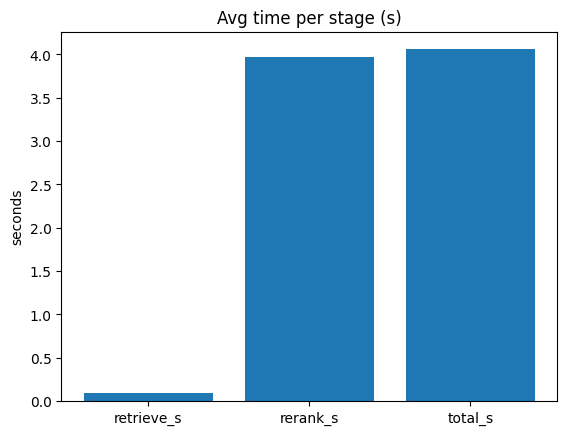

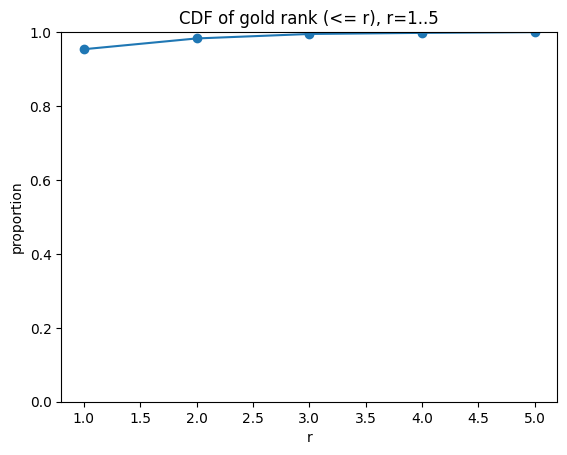

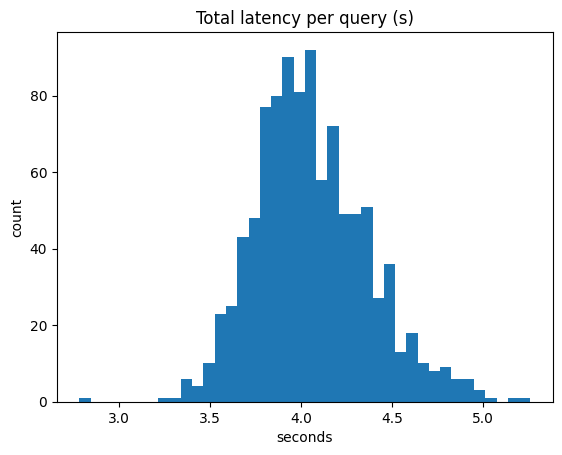

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_time_breakdown(df: pd.DataFrame):
    plt.figure()
    stages = ["retrieve_s", "rerank_s", "total_s"]
    means = [df[s].mean() for s in stages]
    plt.bar(stages, means)
    plt.title("Avg time per stage (s)")
    plt.ylabel("seconds")
    plt.show()

def plot_rank_cdf(df: pd.DataFrame, k_final: int = 5):
    plt.figure()
    col = f"gold_rank@{k_final}"
    ranks = df[col].replace(0, np.nan).dropna().astype(int)
    counts = [(ranks <= r).mean() for r in range(1, k_final + 1)]
    plt.plot(range(1, k_final + 1), counts, marker="o")
    plt.title(f"CDF of gold rank (<= r), r=1..{k_final}")
    plt.xlabel("r")
    plt.ylabel("proportion")
    plt.ylim(0, 1)
    plt.show()

def plot_total_latency(df: pd.DataFrame, bins: int = 40):
    plt.figure()
    plt.hist(df["total_s"], bins=bins)
    plt.title("Total latency per query (s)")
    plt.xlabel("seconds")
    plt.ylabel("count")
    plt.show()

plot_time_breakdown(details)
plot_rank_cdf(details, k_final=5)
plot_total_latency(details)

*4. Выводы*

- Целевая метрика MRR@5 достигнута, система корректно извлекает релевантные документы.

- Основное узкое место - реранкер (≈95% времени на запрос), тогда как поиск по индексу работает быстро.

- Для ускорения можно сократить число кандидатов, длину текста для реранка (trunc_words_doc) или заменить реранкер на более лёгкую модель.

- При масштабировании можно использовать индекс IVF/HNSW для ускорения поиска.